# Summary
In this project, we will use the deduplication and blocking technique in order to reduce the number of comparisons for large dataset. Data deduplication can be applied in numerous fields of computing in research and other applications, such computer vision, NLP etc, but also importantly is reffered to a single instance storage, avoiding repeated data in the storage system.

The objective of this exercise is to deduplicate records from a dataset containing information about people (student.csv file) such as:
- given_name
- surname
- street_number
- adress_1
- adress_2
- suburb
- postcode
- state
- date_of birth


The goal is to detect records that represent the same person. 
The result of this part is a set of record pairs (record_id1, record_id1) that represent the same individual. 

Each recordset will be identified by a unique identifier: 'record_ID'.
The 'soc_sec_id' field will be then used to check the quality of the duplication detection. It can be assumed that it corresponds to the unique identifier of the American social security (In reality, this field is represented by 9 digits, instead of 8); 

Finally, the quality of the duplication detection will be measured from the $precision$ (find duplicated record set: True Positive) and from the $recall$ in order to not considering pairs that are not (False Positive).
Given the size of the sample (~25K rows), a special attention will be paid to the speed of execution.

It should also be noted that a recordset can be duplicated more than two times.


# Strategy applied:
- First analysis of the data and its distribution, missing values are an entry point to the right track of optimal strategies

- The first proposed method will be the "Blocking" type with 2 stages (without worrying about the missing data):
    - stage 1: using the 'state' field;
    - stage 2: using the 'date of birth' field which will be processed in numeric and will therefore allow a vectorization using numpy and finally a test on the 'postcode' field;

This method allows a treatment of the whole sample in a few seconds.

The second method will be very close to the first one by splitting the sample in 2:
  - sample 1: only the recordset without missing data on 'state', 'date_of_birth', 'postcode' and application of method 1;
  - sample 2: recordset with missing data but using NLP;

A 3rd attempt will be made using the blocking method on 'state' plus a score on 6 fields taking into account the missing data.

In [ ]:
!pip install pandas_profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install missingno

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pandas-profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import csv
import pprint
import pandas as pd
import numpy as np
import os
import nltk
from pandas_profiling import ProfileReport
from pandas_profiling.utils.cache import cache_file
import missingno as mso
from numbers import Integral, Real
import missingno as msno
import time
import json
from google.colab import auth

<ipython-input-6-3d1b61d9fc0c>:7: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


# Data Acquisition

In [ ]:
# Keeping connection on Colab:
def ConnectButton():
  {
    console.log("Running..."):
    document.querySelector("colab-connect-button#connect").click()
  }
  setInterval(ConnectButton, 60000)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Downloading our csv file from our Google Drive:
data = pd.read_csv('/content/drive/MyDrive/etudiant.csv')

# Data Analysis and Anomalies identification

In [ ]:
print(data.head(3))

  given_name surname  street_number        address_1        address_2  \
0   matthwew   apted           18.0  atherton srteet  currumb in hill   
1    william  badger            NaN    dwyer s treet          glenlee   
2     connor  bailke          186.0     lambie place              NaN   

             suburb  postcode state  date_of_birth  soc_sec_id id record  
0    port macquarie      3183   vic     19590825.0     9425976       B_0  
1  west lakes shore      3291   nsw     19001210.0     4656608       B_1  
2      port lincoln      7303   qld     19670529.0     4702335       B_2  


In [ ]:
#print(data.tail(5))

Over 3 tuples, we can already notice some typos on the street name address for example, as well as missing data on the 'street_number' column.

In [ ]:
%time #time execution measure 1000 microsecs

data_rows = len(data)

print("Total Unique id record: ", data['id record'].nunique())
print("Total Unique 'soc_sec_id' record: ", data['soc_sec_id'].nunique())
print("Total Number Of Rows and Columns: ", data.shape)
print('-' * 39)
print("Column Type: ")
print(f"{data.dtypes.value_counts()}")
# Free more space from RAM, useful for big DF
del data_rows

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs
Total Unique id record:  24940
Total Unique 'soc_sec_id' record:  5257
Total Number Of Rows and Columns:  (24940, 11)
---------------------------------------
Column Type: 
object     7
float64    2
int64      2
dtype: int64


In [ ]:
# Descriptive statistics for each numeric column
data.describe()

,street_number,postcode,date_of_birth,soc_sec_id
count,23482.000000,24940.000000,2.393200e+04,2.494000e+04
mean,84.322119,3695.033160,1.948750e+07,5.479690e+06
std,403.139877,1426.051286,2.901448e+05,2.587337e+06
min,1.000000,216.000000,1.900011e+07,1.000123e+06
25%,9.000000,2504.000000,1.923042e+07,3.254495e+06
50%,23.000000,3201.000000,1.948607e+07,5.448033e+06
75%,57.000000,4670.000000,1.974023e+07,7.719637e+06
max,14430.000000,9319.000000,1.999122e+07,9.996479e+06



*   Full count of rows (24940), with some features composed by NAN values
* soc_sec_id is an interesting feature which could give us more infos on specific different students based on the social security unique ID. It tells us basically how many different student we could have over the full dataset: 5257 - which would mean that 19683 rows are duplicate?

# Missing data repartition
Visualization is also very useful with a good librairy "missingno" and the function msno.matrix is used to visualize missing data in a DataFrame

<AxesSubplot: >

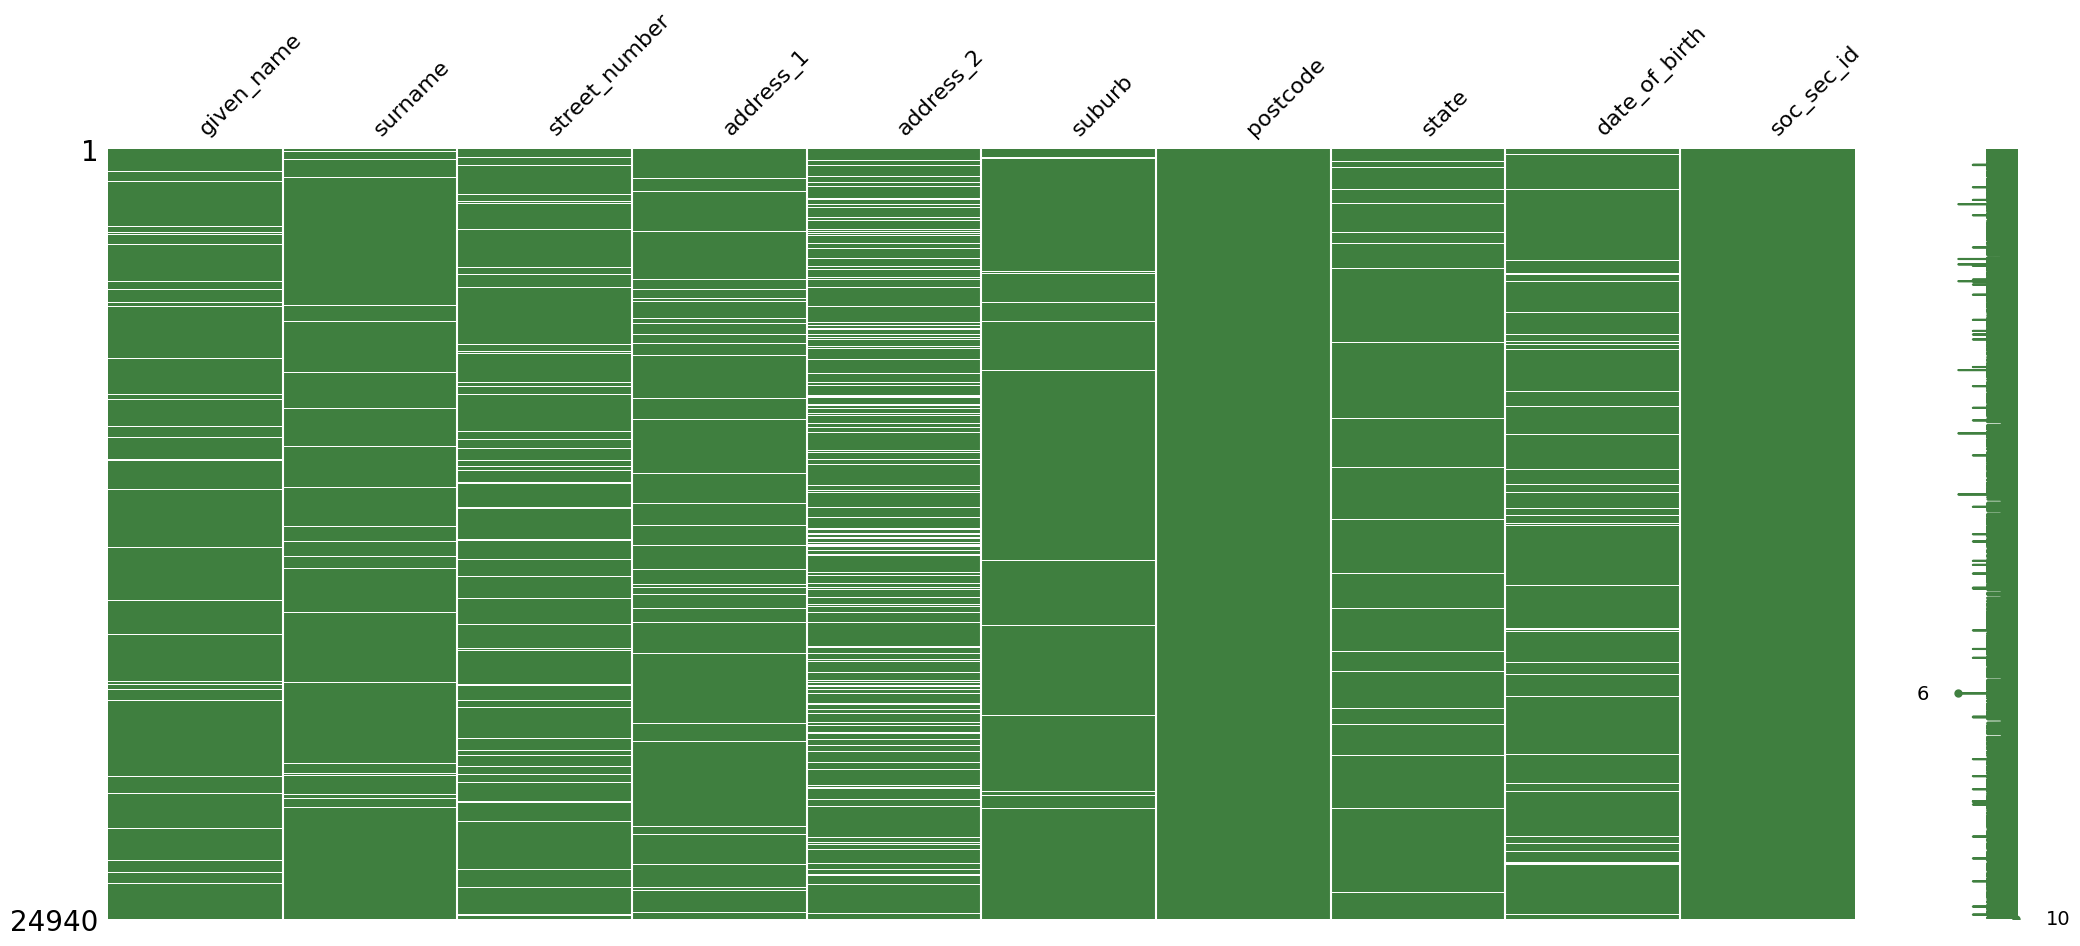

In [ ]:
msno.matrix(data[['given_name', 'surname', 'street_number', 'address_1', 'address_2',
       'suburb', 'postcode', 'state', 'date_of_birth', 'soc_sec_id']], color=(0.25, 0.5, 0.25))

The pandas_profiling library generates a profiling report and creates an interactive report that provides an in-depth look at the structure, statistics and relationships present in our *students* dataset:



In [ ]:
profile = ProfileReport(data[['given_name', 'surname', 'street_number', 'address_1', 'address_2',
       'suburb', 'postcode', 'state', 'date_of_birth', 'soc_sec_id']], title="Census Dataset", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 1] Cleaning steps

In [ ]:
# Let's create a copy of the DataFrame
data1 = data.copy()

In [ ]:
data1.rename(columns={'id record': 'id_record'}, inplace = True) 
data1.dtypes #re-checking type to anticipate future errors 

given_name        object
surname           object
street_number    float64
address_1         object
address_2         object
suburb            object
postcode           int64
state             object
date_of_birth    float64
soc_sec_id         int64
id_record         object
dtype: object

In [ ]:
# Using id record as index 
data1.set_index('id_record')
data1.head().style.set_properties(**{'background-color': None, 
                                      'color': 'white'})

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,id_record
0,matthwew,apted,18.000000,atherton srteet,currumb in hill,port macquarie,3183,vic,19590825.000000,9425976,B_0
1,william,badger,nan,dwyer s treet,glenlee,west lakes shore,3291,nsw,19001210.000000,4656608,B_1
2,connor,bailke,186.000000,lambie place,nan,port lincoln,7303,qld,19670529.000000,4702335,B_2
3,kaitlin,goldsworthy,54.000000,nan,nan,thirroul,2035,nsw,19640517.000000,9127277,B_3
4,jasmyn,lowe,48.000000,toohey place,grand ecntral,bicton,3085,nsw,19320918.000000,1430128,B_4


Additionnally to the profile report made above, I would like to focus more on **'soc_sec_id'** values as *it should be* the feature indicating the uniqueness of a US citizen /or how many unique person should we have here in this dataset.

In [ ]:
occurrences = data1['soc_sec_id'].value_counts()
mask = occurrences > 1

#repeated_values = occurrences[masque].index.tolist()
mask.value_counts()

True     4968
False     289
Name: soc_sec_id, dtype: int64

Indeed, this confirms the Pandas Profiling report where we can see that 4968 values are duplicates of 'soc_sec_id', herebelow an example of 'soc_sec_id' being similar 8 times and pointing one single person:

In [ ]:
# Analyzing duplicates & frequency of 'soc_sec_id':
duplicates = data1['soc_sec_id'].value_counts()
duplicates = duplicates[duplicates>1]
print(duplicates)
del duplicates

8646353    8
6079337    8
3515659    8
5875656    8
3423612    8
          ..
6244854    2
7581364    2
1573421    2
9676170    2
4368305    2
Name: soc_sec_id, Length: 4968, dtype: int64


In [ ]:
len(data1['soc_sec_id'])

24940

Feature analysis when ['soc_sec_id'] == 8646353] and visualization of differences on all tuples:

In [ ]:
data1[data1['soc_sec_id'] == 8646353]

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,id_record
597,daish,william,500.0,osburn drive,pink lake caravan park,eastwood,3085,nsw,19311114.0,8646353,B_597
847,daish,william,500.0,osburn drive,pink lake caravan park,eastwood,3085,nsw,19311114.0,8646353,B_847
1714,daish,william,500.0,osburn drive,pink lake caravan park,eastwood,3085,nsw,19311114.0,8646353,B_1714
18050,daish,william,500.0,osburn drive,pink lake caravan park,eastwood,3085,nsw,19311114.0,8646353,B_18050
21489,daish,william,500.0,osburn drive,pink lake caravan park,eastwood,3085,nsw,19311114.0,8646353,B_21489
21985,daish,william,500.0,osburnadrive,pink lake caravan park,eastwood,3085,nsw,19311114.0,8646353,B_21985
22674,daish,william,500.0,osburn drive,pink lake caravan park,eastwood,3085,nsw,19311114.0,8646353,B_22674
22726,daish,william,500.0,osburn drive,pink lake caravan park,eastwood,3085,nsw,19311114.0,8646353,B_22726


Jaccard and Levenshtein Distance applied calculation between above rows #21489 and #21985, using the NLTK (Natural Language Toolkit) library:

- The Jaccard distance measures the dissimilarity between two sets by taking into account the number of elements common to both sets and the total number of distinct elements;
- The Levenshtein distance measures the difference between two strings by counting the minimal number of operations (insertion, deletion, substitution) necessary to transform one into the other.

In [ ]:
print('Distance test rows #21489 and #2198: ')
print(' distance jaccard {}, distance Levenshtein {}'.
      format(nltk.jaccard_distance(set(data1.loc[21985,'address_1']), set(data1.loc[21489,'address_1'])),
             nltk.edit_distance(data1.loc[21985,'address_1'],data1.loc[21489,'address_1'])
      ))

Distance test rows #21489 and #2198: 
 distance jaccard 0.16666666666666666, distance Levenshtein 1


Results analysis means that the two sets of characters in the addresses have a similarity of about 83.33% (1 - 0.166666666666666 = 0.83333333333333). Also, the Levenshtein distance is 1, which means that only one operation is needed to transform one of the addresses into the other. So the tuples are very similar.



We have also the case where 'soc_sec_id' is different but the person is the same. We would however use this variable in order to proceed to quality assessment on 3] Part of this notebook. Jaccard distance is also applied when 2 tuples seem completely different in order to evaluate the level of output.

In [ ]:
data1[data1['id_record'].isin(('B_5', 'B_11993'))] # Same person but soc_sec_id different

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,id_record
5,joshua,coleman,16.0,mosman place,aarlee,koouong,3432,nsw,19501024.0,2640319,B_5
11993,joshua,coleman,16.0,mosman place,aarlee,koouong,3432,nsw,19501024.0,2640324,B_11993


In [ ]:
print('Distance test joshua coleman')
print(' distance jaccard {},  Levenshtein {}'.
      format(nltk.jaccard_distance(set(data1.loc[5,'address_1']), set(data1.loc[21489,'address_1'])),
             nltk.edit_distance(data1.loc[5,'address_1'],data1.loc[21489,'address_1'])
      ))

Distance test joshua coleman
 distance jaccard 0.6875,  Levenshtein 8


In summary, these two measures for  "joshua coleman" show a Jaccard distance of 0.6875 (a similarity of about 31.25%) and a Levenshtein distance of 8, indicating that eight operations are required to transform one of the strings into the other (in IDs only).

This function will help us to set an output as 0 when a value in date_of_birth is missing, and 1 when the value is here:

In [ ]:
#isinstance(data1.loc[30,'date_of_birth'],str)
#isinstance(data1.loc[31,'date_of_birth'],str)
type(data1.loc[31,'date_of_birth'])

numpy.float64

In [ ]:
type(data1.loc[30,'date_of_birth'])

numpy.float64

In [ ]:
data1.loc[30,'date_of_birth']

nan

The below function isnumber checks if the variable x is an integer (Integral) or a real number (Real) and returns True if it is, otherwise it returns False. The function uses the numbers module for type checks and the pandas (pd) module to check if the value is not null (NaN):

In [ ]:
from numbers import Integral, Real
def isnumber(x):
    return ((isinstance(x, Integral) | isinstance(x, Real)) & ~pd.isnull(x))

In [ ]:
isnumber(data1.loc[31,'date_of_birth'])

1

## Just for fun, Analysis of potential duplicates on some features : 'date_of_birth', 'id_record'
This can give a rough idea on important features normally used to differentiate people;

In [ ]:
# Detect duplicates in the 'id record' column
duplicatesid = data1['id_record'].duplicated(keep=False)
duplicates_valuesid = data1.loc[duplicatesid, 'id_record'].value_counts()
print(duplicates_valuesid) # no duplicate so id_record is "normally" distributed

Series([], Name: id_record, dtype: int64)


No duplicate on ID record, which is quite important to verify.

In [ ]:
data2 = data1.copy()

We have previously observed a lot of typos in the dataset within the variable 'address_1' and 'address_2', where **street** contains a lot of wrong spelling street words:

Let's try to clean a bit:

In [ ]:
#clean
import re

def clean_street(text):
    if isinstance(text, str):
        pattern = r'\b(?:st\.?|str\.?|strt\.?|street|s treet\.?|sjreet\.?)\b'
        return re.sub(pattern, 'street', text, flags=re.IGNORECASE)
    return text

data2['address_1'] = data2['address_1'].apply(clean_street)
data2['address_2'] = data2['address_2'].apply(clean_street)

In [ ]:
#merge addresses?

In [ ]:
#merge noms?

In [ ]:
#nettoyage street number?

# 2] Blocking method

Applying an exhaustive search where all peers in the data set are compared can take a lot of time. In order to reduce the number of comparison to make, the "blocking" method can be implemented by specify blocks. A quick reminder on uniqueness of values per feature can inspire on the features selection: 

In [ ]:
data2.nunique().loc[['soc_sec_id', 'given_name', 'id_record', 'surname', 'street_number', 'address_1', 'address_2', 'suburb', 'postcode', 'state', 'date_of_birth']]

soc_sec_id        5257
given_name        2090
id_record        24940
surname           3051
street_number      461
address_1         3914
address_2         3676
suburb            3242
postcode          1796
state              269
date_of_birth     4747
dtype: int64

A choice of a good partitioning predicate on the right feature is important. A typical partitioning is by zip code, last name, street name etc. For our dataset, let's apply the blocking method into the:
- 'state', 'date_of_birth' and 'address_1' features by filtering groups of more than 10 similar values. 
'Address_2' might not be a primary feature, even though we could still keep it.
Let's check this out:

The 'state' feature, contains only 526 missing values will be used for our first block and 269 different values, which could be interesting for our first block:

In [ ]:
state ='state'
group_sizes = pd.DataFrame(data2.groupby(state)[state].count())
group_sizes.columns = ['number']
group_sizes.sort_values(by = 'number',ascending=False).head(8) #sorting groups by DESC

,number
state,
nsw,8011
vic,5768
qld,4443
wa,2246
sa,1844
tas,653
act,315
nt,141


A little bit of data viz doesn't kill anyone :)

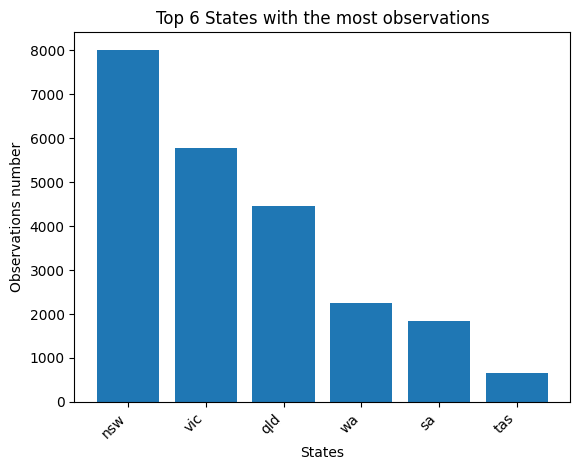

In [ ]:
import matplotlib.pyplot as plt

top_6_group_sizes = group_sizes.sort_values(by='number', ascending=False).head(6)

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(top_6_group_sizes.index, top_6_group_sizes['number'])
ax.set_title('Top 6 States with the most observations')
ax.set_xlabel('States')
ax.set_ylabel('Observations number')
plt.xticks(rotation=45, ha='right')
plt.show()

5 states stand out from the group, confirming the distribution.

Looking at the results above, it seems that a strategy that can be used would be to create 6 blocks:

* A block containing states located in nsw
* A block containing states located in vic
* A block containing states located in qld
* A block containing states located in wa
* A block containing states located in sa
* A block containing states located in any of the remaining states

Within 'block_state' created we will then proceed to matches comparison with time efficiency:

The below code, deals with extracting and displaying specific information from our dataset. We filter the data to retain only those rows whose 'state' column contains the state "nsw", in order to find the indexes where the value of 'date_of_birth' is equal to the value of the index row i:

In [ ]:
i = 3
block = data2[data2['state'].str.contains("nsw", na = False)]
block.reset_index(drop = True,inplace = True)
print('block','nsw',block['date_of_birth'][i],'given_name',block['given_name'][i],' post code ',block['postcode'][i])
tab = np.array(block['date_of_birth'][i:])

block nsw 19501024.0 given_name joshua  post code  3432


In [ ]:
tab = np.array(block['date_of_birth'][i:])
tab

array([19501024., 19200828., 19381228., ..., 19641111., 19770628.,
       19610906.])

In [ ]:
index = np.argwhere(tab == block['date_of_birth'][i])
index

array([[   0],
       [1197],
       [3876],
       [4397],
       [5607],
       [6446],
       [6905],
       [7793]])

In [ ]:
for j in index:
  display(block.loc[j+i,:])

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,id_record
3,joshua,coleman,16.0,mosman place,aarlee,koouong,3432,nsw,19501024.0,2640319,B_5


,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,id_record
1200,joshua,coleman,16.0,mosman place,aarlee,koouong,3432,nsw,19501024.0,2640319,B_3746


,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,id_record
3879,joshua,coleman,16.0,mosman place,aarlee,koouong,3432,nsw,19501024.0,2640324,B_11993


,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,id_record
4400,joshua,coleman,16.0,mosman place,aarlee,koouong,3432,nsw,19501024.0,2640319,B_13612


,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,id_record
5610,joshua,coleman,16.0,mosman place,aarlee,koouong,3432,nsw,19501024.0,2640319,B_17385


,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,id_record
6449,joshua,coleman,16.0,mosman place,aarlee,koouong,3432,nsw,19501024.0,2640319,B_19960


,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,id_record
6908,joshua,coleman,16.0,mosman place,aarlee,koouong,3432,nsw,19501024.0,2640319,B_21329


,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,id_record
7796,joshua,coleman,16.0,mosman place,aarlee,koouong,3432,nsw,19501024.0,2640319,B_24094


## 2.1. Blocking method on 'state', 'date_of _birth' and 'address_1':


In [ ]:
#creation of blocks
blocks_state = []
data2['state'] = data2['state'].fillna('') 
block_st_1 = data2[data2['state'].str.contains("nsw")]
block_st_2 = data2[data2['state'].str.contains("vic")]
block_st_3 = data2[data2['state'].str.contains("qld")]
block_st_4 = data2[data2['state'].str.contains("wa")]
block_st_5 = data2[data2['state'].str.contains("sa")]
block_st_6 = data2[data2['state'].str.contains("nsw|qld|vic|qld|wa|sa")== False]
blocks_state.append(block_st_1) 
blocks_state.append(block_st_2)
blocks_state.append(block_st_3)
blocks_state.append(block_st_4)
blocks_state.append(block_st_5)
blocks_state.append(block_st_6)
num_records = len(data2)
matches2 = []
number_of_matches2 = 0
start = time.process_time()
k = 0

'''
The below code checks if the dates of birth are the same, in that case
the Jaccard distance between the address_1 strings is calculated. 
If this distance is less than 0.2, the IDs of the corresponding records 
are added to the matches2 list, and the counter number_of_matches2 is incremented:
'''
for block in blocks_state:
    block.reset_index(inplace=True)
    num_records = len(block)
    for i in range(0,num_records):
        tab = np.array(block['date_of_birth'][i:])
        index = np.argwhere(tab == block['date_of_birth'][i])
        index = index+i
        if len(index)!= 0:
            for j in range(0,len(index)):
                  if i != int(index[j]):
                      if ( isinstance(block.loc[i,'address_1'],str) & isinstance(block.loc[int(index[j]),'address_1'],str)) :
                          if nltk.jaccard_distance(set(block.loc[i,'address_1']), set(block.loc[int(index[j]),'address_1']))<0.2:
                            number_of_matches2 = number_of_matches2 +1 
                            matches2.append((block.loc[i,'id_record'],block.loc[int(index[j]),'id_record']))    
    
end = time.process_time()

print("Number of matches within 'States' blocks: {}".format(number_of_matches2)) #matches do not consider soc_sec_id
print("Processing time: {:.4f}".format(end - start))    

Number of matches within 'States' blocks: 52700
Processing time: 7.7295


Here below we create a DF called 'pair' containing pairs of records with the same social security number (soc_sec_id), by filtering the rows of the resulting DF to keep only those where record_ID_a is less than record_ID_b. This avoids duplicates and auto-couplings (when a record is associated with itself). The rows are sorted by record_ID_a and record_ID_b, then displayed:

In [ ]:
pair = data2.copy()
pair["indice"] = pair.index
pair.insert(0, 'record_ID', range(0, len(pair)))
pair = pd.merge(left = pair, right = pair, on = "soc_sec_id", suffixes = ("_a","_b"), how = "right")
pair = pair.query('record_ID_a < record_ID_b').sort_values(['record_ID_a','record_ID_b'])
pair[['id_record_a','id_record_b']].sort_values(['id_record_a','id_record_b']).head()

,id_record_a,id_record_b
24399,B_0,B_4258
5910,B_1,B_1040
94050,B_1,B_16465
136407,B_1,B_23861
102595,B_10,B_17952


In short, this helps to create all unique pairs of records in "data2" using the "soc_sec_id" column as the join key, which is useful for detecting duplicates or similar records in a database.



In [ ]:
pair['id_record_a'].nunique()

19683

In [ ]:
len(matches2)

52700

Then we compute the precision, recall and F-measure by comparing the pairs of matches obtained in the two approaches: matches based on birth dates and addresses (matches2, computed previously) and matches based on social security numbers (LPair, computed in the previous code):

In [ ]:
LPair = []
for i in range(pair.shape[0]):
    LPair.append((pair["id_record_a"].iloc[i],pair["id_record_b"].iloc[i]))

Reminder: 
Several metrics exist to evaluate the effectiveness of object identification techniques. The most typical
metrics are recall and precision.
- Recall measures how many true positives are identified in relation to the total number of actual
matches.
- Precision measures how many true matches are identified in relation to the total number of
declared matches, including erroneous ones (i.e., FPs)
- In order to combine recall and precision, F-measure has also been proposed. It corresponds to the
harmonic mean of recall and precision.

In [ ]:
#Calculates TPs by finding the elements present in both matches2 and LPair:
TP = [m for m in matches2 if m in LPair]
#Calculates FPs by finding the elements present in matches2, but not in LPair:
FP = [m for m in matches2 if (m in LPair) == False]
#Calculates FNs by finding the elements present in LPair, but not in matches2:
FN = [l for l in LPair if (l in matches2) == False]
#Calculates the precision as follows: TP / (TP + FP):
precision = len(TP)/(len(TP)+len(FP))
#Calculates the recall as follows: TP / (TP + FN):
recall = len(TP)/(len(TP)+len(FN))
#Computes the F-score as follows: 2 * (recall * precision) / (recall + precision):
F = 2*(recall * precision) / (recall + precision)
print('Precision {:.4f}, Recall {:.4f}, Fscore {:.4f}'.format (precision,recall,F)) 

Precision 0.9819, Recall 0.8799, Fscore 0.9281


## 2.2. Blocking method on 'state', 'date_of _birth' and 'postcode':

In [ ]:
blocks_state = []
data2['state'] = data2['state'].fillna('') 
block_st_1 = data2[data2['state'].str.contains("nsw")]
block_st_2 = data2[data2['state'].str.contains("vic")]
block_st_3 = data2[data2['state'].str.contains("qld")]
block_st_4 = data2[data2['state'].str.contains("wa")]
block_st_5 = data2[data2['state'].str.contains("sa")]
block_st_6 = data2[data2['state'].str.contains("nsw|qld|vic|qld|wa|sa")== False]
blocks_state.append(block_st_1) 
blocks_state.append(block_st_2)
blocks_state.append(block_st_3)
blocks_state.append(block_st_4)
blocks_state.append(block_st_5)
blocks_state.append(block_st_6)
num_records = len(data2)
matches1 = []
number_of_matches1 = 0
start = time.process_time()
k = 0

for block in blocks_state:
    block.reset_index(inplace=True)
    num_records = len(block)
    for i in range(0,num_records):
        tab = np.array(block['date_of_birth'][i:])
        index = np.argwhere(tab == block['date_of_birth'][i])
        index = index+i
        if len(index)!= 0:
            for j in range(0,len(index)):
                  if i != int(index[j]):
                      if block.loc[i,'postcode'] == block.loc[int(index[j]),'postcode']:
                          number_of_matches1 = number_of_matches1 +1 
                          matches1.append((block.loc[i,'id_record'],block.loc[int(index[j]),'id_record']))    
    
end = time.process_time()

print("Number of matches: {}".format(number_of_matches1))
print("Processing time: {:.4f}".format(end - start))    

Number of matches: 54045
Processing time: 3.7357


In [ ]:
pair = data2.copy()
pair["indice"] = pair.index
pair.insert(0, 'record_ID', range(0, len(pair)))
pair = pd.merge(left = pair, right = pair, on = "soc_sec_id", suffixes = ("_a","_b"), how = "right")
pair = pair.query('record_ID_a < record_ID_b').sort_values(['record_ID_a','record_ID_b'])
LPair = []
for i in range(pair.shape[0]):
    LPair.append((pair["id_record_a"].iloc[i],pair["id_record_b"].iloc[i]))
TP = [m for m in matches1 if m in LPair]
FP = [m for m in matches1 if (m in LPair) == False]
FN = [l for l in LPair if (l in matches1) == False]
precision = len(TP)/(len(TP)+len(FP))
recall = len(TP)/(len(TP)+len(FN))
F = 2*(recall * precision) / (recall + precision)
print('precision {:.4f} recall {:.4f} Fscore {:.4f}'.format (precision,recall,F)) 

precision 0.9815 recall 0.9021 Fscore 0.9401


## 2.3. Blocking method on 'state' + *SCORING* on date_of_birth 'address_1','address_2','given_name','surname','suburb'

Here, we apply the blocking method on the state and then use the date_of_birth as a quickly computed feature using a numpy array. We distinguish two cases when there is a missing value for date_of_birth:

- If the date_of_birth is present, we search for Jaccard distances on 4 out of 5 variables, ensuring that we do not have missing data for these variables:
 = ['address_1', 'address_2', 'given_name', 'surname', 'suburb']

- If the date_of_birth has missing data, then we want to find close matches (Jaccard) for all 5/5 variables:


In [ ]:
# with scoring
blocks_state = []
data2['state'] = data2['state'].fillna('') 
block_st_1 = data2[data2['state'].str.contains("nsw")]
block_st_2 = data2[data2['state'].str.contains("vic")]
block_st_3 = data2[data2['state'].str.contains("qld")]
block_st_4 = data2[data2['state'].str.contains("wa")]
block_st_5 = data2[data2['state'].str.contains("sa")]
block_st_6 = data2[data2['state'].str.contains("nsw|qld|vic|qld|wa|sa")== False]
blocks_state.append(block_st_1) 
blocks_state.append(block_st_2)
blocks_state.append(block_st_3)
blocks_state.append(block_st_4)
blocks_state.append(block_st_5)
blocks_state.append(block_st_6)
num_records = len(data2)
matches3 = []
number_of_matches3 = 0
start = time.process_time()
k = 0

variables =['address_1','address_2','given_name','surname','suburb']
l=len(variables)


for block in blocks_state:
    
    block.reset_index(inplace = True)
    num_records = len(block)
    for i in range(0,num_records):
        tab = np.array(block['date_of_birth'][i:])
        
        if isnumber(data1.loc[i,'date_of_birth']):  # not missing
          
          index = np.argwhere(tab == block['date_of_birth'][i])
          index = index+i
          if len(index)!= 0:
              for j in range(0,len(index)):
                    score=0
                    
              
                    if i != int(index[j]):
                        for v in variables:
                          if ( isinstance(block.loc[i,v],str) & isinstance(block.loc[int(index[j]),v],str)) :
                              if nltk.jaccard_distance(set(block.loc[i,v]), set(block.loc[int(index[j]),v]))<0.16: score=score+1
                             
                        if score>=max((l-1),1) : # we collect 4/5 jaccard distances
                              number_of_matches3 = number_of_matches3 +1 
                              matches3.append((block.loc[i,'id_record'],block.loc[int(index[j]),'id_record']))    
        else: # birth_of_date is empty
          index = np.argwhere(tab == block['date_of_birth'][i])
          index = index+i
          if len(index)!= 0:
              for j in range(0,len(index)):
                    score=0
                    
              
                    if i != int(index[j]):
                        for v in variables:
                          if (isinstance(block.loc[i,v],str) & isinstance(block.loc[int(index[j]),v],str)) :
                              if nltk.jaccard_distance(set(block.loc[i,v]), set(block.loc[int(index[j]),v]))<0.16: score=score+1
                             
                        if score>=l : # we collect 5 distances
                              number_of_matches3 = number_of_matches3 +1 
                              matches3.append((block.loc[i,'id_record'],block.loc[int(index[j]),'id_record']))    
    

end = time.process_time()

print("Number of matches: {}".format(number_of_matches3))
print("Processing time: {:.4f}".format(end - start)) 

Number of matches: 52103
Processing time: 14.2666


# 3] Quality Assessement

Here we create a function "clean" which will demultiply matches in order to keep only one record in our assessment : e.g. : 

*B1 == B3* and *B1 == B2* count as 2 matches

BUT we are not taking into account *B2 == B3* 

In [ ]:
from collections import defaultdict

In [ ]:
def clean(l1):
    dic = defaultdict(list)

    for i,j in l1:
        dic[i].append(j)
        dic[j].append(i)
    
    dic2 = dic.copy()
    for i in dic.keys():
        l = [i] + dic[i]
        mini = min(l)
        for value in l:
            if value > mini:
                dic2.pop(value, None)

    l2 = []

    for key in dic2.keys():
        l = dic2[key]
        for v in l:
            l2.append((key,v))
    return(l2) 

In [ ]:
len(LPair)

58807

Let's clean up! :

In [ ]:
len(clean(LPair))

19683

In [ ]:
data2['soc_sec_id'].nunique()

5257

In [ ]:
len(data2)

24940

In [ ]:
19683 + 5257

24940

The code above uses different rules and change the distances used for matching the attributes values. In essence, a cleaning program needs to minimize the overall execution time without compromising the quality of the results. Before doing so, we show below how can we assess the results obtained by comparing them to the ground truth results, by placing ourselves into the 'soc_sec_id' attribute:

In [ ]:
pair = data2.copy()
pair["indice"] =pair.index
pair.insert(0, 'record_ID', range(0, len(pair)))
pair = pd.merge(left=pair,right=pair,on="soc_sec_id",suffixes=("_a","_b"),how="right")
pair = pair.query('record_ID_a < record_ID_b').sort_values(['record_ID_a','record_ID_b'])
LPair = []
for i in range(pair.shape[0]):
    LPair.append((pair["id_record_a"].iloc[i],pair["id_record_b"].iloc[i]))
TP = [m for m in matches3 if m in LPair]
FP = [m for m in matches3 if (m in LPair)==False]
FN = [l for l in LPair if (l in matches3)==False]
precision=len(TP)/(len(TP)+len(FP))
recall=len(TP)/(len(TP)+len(FN))
F = 2*(recall * precision) / (recall + precision)
print('precision {:.4f} recall {:.4f} Fscore {:.4f}'.format (precision,recall,F))

precision 0.9815 recall 0.8696 Fscore 0.9222


Analysis with "clean" function:

In [ ]:
cl_mat = clean(matches3)
cl_lpair = clean(LPair)

In [ ]:
pair = data2.copy()
pair["indice"] = pair.index
pair.insert(0, 'record_ID', range(0, len(pair)))
pair = pd.merge(left = pair, right = pair, on = "soc_sec_id",suffixes = ("_a","_b"), how = "right")
pair = pair.query('record_ID_a < record_ID_b').sort_values(['record_ID_a','record_ID_b'])
LPair = []
for i in range(pair.shape[0]):
    LPair.append((pair["id_record_a"].iloc[i],pair["id_record_b"].iloc[i]))
TP = [m for m in cl_mat if m in cl_lpair]
FP = [m for m in cl_mat if (m in cl_lpair) == False]
FN = [l for l in cl_lpair if (l in cl_mat) == False]
precision = len(TP)/(len(TP)+len(FP))
recall = len(TP)/(len(TP)+len(FN))
F = 2*(recall * precision) / (recall + precision)
print('precision {:.4f} recall {:.4f} Fscore {:.4f}'.format (precision,recall,F))

precision 0.9548 recall 0.8555 Fscore 0.9024


## True Positives
Here we have the true duplicates on records, where only 'id_record' is different between each tuple:

In [ ]:
display(pd.DataFrame(TP))
display(data[data['id record'].isin(['B_1','B_1040','B_16465','B_23861'])])

,0,1
0,B_1,B_1040
1,B_1,B_16465
2,B_1,B_23861
3,B_1490,B_4
4,B_15,B_16347
...,...,...
16833,B_18391,B_19089
16834,B_18391,B_20374
16835,B_19201,B_19386
16836,B_19942,B_22778


,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,id record
1,william,badger,NaN,dwyer s treet,glenlee,west lakes shore,3291,nsw,19001210.0,4656608,B_1
1040,william,badger,NaN,dwyer s treet,glenlee,west lakes shore,3291,nsw,19001210.0,4656608,B_1040
16465,william,badger,NaN,dwyer s treet,glenlee,west lakes shore,3291,nsw,19001210.0,4656608,B_16465
23861,william,badger,NaN,dwyer s treet,glenlee,west lakes shore,3291,nsw,19001210.0,4656608,B_23861


##False Negatives
The below FN are detected as non duplicates, when they should be:

In [ ]:
display(pd.DataFrame(FN))
display(data[data['id record'].isin(['B_3','B_518','B_4226','B_6490','bB_9486'])])

,0,1
0,B_12048,B_3
1,B_12048,B_518
2,B_12048,B_4226
3,B_12048,B_6490
4,B_12048,B_9486
...,...,...
2840,B_21523,B_22423
2841,B_21584,B_22888
2842,B_21983,B_24217
2843,B_22452,B_24663


,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,id record
3,kaitlin,goldsworthy,54.0,NaN,NaN,thirroul,2035,nsw,19640517.0,9127277,B_3
518,kaitlin,goldsworthy,54.0,NaN,NaN,thirroul,2035,nsw,19640517.0,9127277,B_518
4226,kaitlin,goldsworthy,54.0,NaN,NaN,thirroul,2035,nsw,19640517.0,9127277,B_4226
6490,kaitlin,goldsworthy,54.0,NaN,NaN,thirroul,2035,nsw,19640517.0,9127277,B_6490


It can be explained because of the missing values in 'address_1' & 'address_2'

## False Positives
Are the ones detected as matches when they should not be.

In [ ]:
display(pd.DataFrame(FP))
display(data[data['id record'].isin(['B_5','B_11993'])])

,0,1
0,B_11993,B_5
1,B_11993,B_3746
2,B_11993,B_13612
3,B_11993,B_17385
4,B_11993,B_19960
...,...,...
793,B_13479,B_15171
794,B_13479,B_16571
795,B_13479,B_19772
796,B_13479,B_19822


,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,id record
5,joshua,coleman,16.0,mosman place,aarlee,koouong,3432,nsw,19501024.0,2640319,B_5
11993,joshua,coleman,16.0,mosman place,aarlee,koouong,3432,nsw,19501024.0,2640324,B_11993


These are considered as False Positive, because of the small difference on soc_sec_id values only.

# Conclusion

In [ ]:
len(clean(LPair))

19683

LPair was calculated on 'soc_sec_id', used as the *control variable*. Duplicate records were 19683 according to this calculation. To conclude, we applied the clean function to 'matches3' (taking into account a blocking method on 'state' + *SCORING* on date_of_birth 'address_1','address_2','given_name','surname','suburb') and we can have a better count on the total number of duplicate records at 17636.

Remembering that soc_sec_id wasn't a perfect *control variable* in this exercise.

In [ ]:
len(clean(matches3))

17636

In [ ]:
pd.DataFrame(clean(matches3))

,0,1
0,B_1,B_1040
1,B_1,B_16465
2,B_1,B_23861
3,B_1490,B_4
4,B_11993,B_5
...,...,...
17631,B_18391,B_19089
17632,B_18391,B_20374
17633,B_19201,B_19386
17634,B_19942,B_22778



Data redundancy and huge dimensionality are the factors that affect the performance of computation and speed and utilization of storage. We have presented an overview of data deduplication using Blocking method as well as several distance calculation approaches, which can help in improving the utilization of storage system involved and incresed computational speed. This also helps further analysis by having unique records, when statistics are performed based on large dataset.